In [1]:
import pandas as pd
import gc
import numpy as np

In [2]:
data = pd.read_pickle("/home/wsuser/work/project_data_assets/data_asset/full_data.pkl")
products = pd.read_pickle("/home/wsuser/work/project_data_assets/data_asset/products.pkl")

In [3]:
data = data.merge(products, on = "id")
del products
gc.collect()

14

In [4]:
train_df = data.loc[data.part == 'train']
x_train = train_df.loc[(train_df['date'] > '2015-01-01') & (train_df['date'] <= '2016-03-27')]
y_train = x_train['demand']
x_val = train_df.loc[(train_df['date'] > '2016-03-27') & (train_df['date'] <= '2016-04-24')]
y_val = x_val['demand']
del data, train_df
gc.collect()

0

In [5]:
features = x_train.columns
features = features.drop(["id", "demand", "part", "date", "wm_yr_wk"])

In [6]:
from data_preprocessing import CategoricalEncoder

cat_columns = ['item_id', 'dept_id', 'cat_id', 'store_id', 'state_id']
encoder = CategoricalEncoder(cat_columns)
encoder.encode(x_train)
encoder.encode(x_val)

In [7]:
x_train.fillna(0, inplace = True)
x_val.fillna(0, inplace = True)

In [8]:
!pip install lightgbm

     |################################| 1.2MB 653kB/s eta 0:00:0111


In [9]:
import lightgbm as lgb

train_set = lgb.Dataset(x_train[features], y_train)
val_set = lgb.Dataset(x_val[features], y_val)

In [ ]:
from sklearn.metrics import mean_squared_error

# define random hyperparameters
params = {
    'boosting_type': 'gbdt',
    'metric': 'rmse',
    'objective': 'regression',
    'n_jobs': -1,
    'seed': 42,
    'learning_rate': 0.1,
    'bagging_fraction': 0.75,
    'bagging_freq': 10, 
    'colsample_bytree': 0.75}

model = lgb.train(params, train_set, num_boost_round = 2500, early_stopping_rounds = 50, valid_sets = [train_set, val_set], verbose_eval = 100)
val_pred = model.predict(x_val[features])
val_score = np.sqrt(mean_squared_error(val_pred, y_val))
print(f'Our val rmse score is {val_score}')

del train_set, val_set
gc.collect()

Training until validation scores don't improve for 50 rounds
[100]	training's rmse: 2.19254	valid_1's rmse: 2.12401
[200]	training's rmse: 2.14338	valid_1's rmse: 2.11461
[300]	training's rmse: 2.11231	valid_1's rmse: 2.11136
Early stopping, best iteration is:
[254]	training's rmse: 2.12593	valid_1's rmse: 2.11085


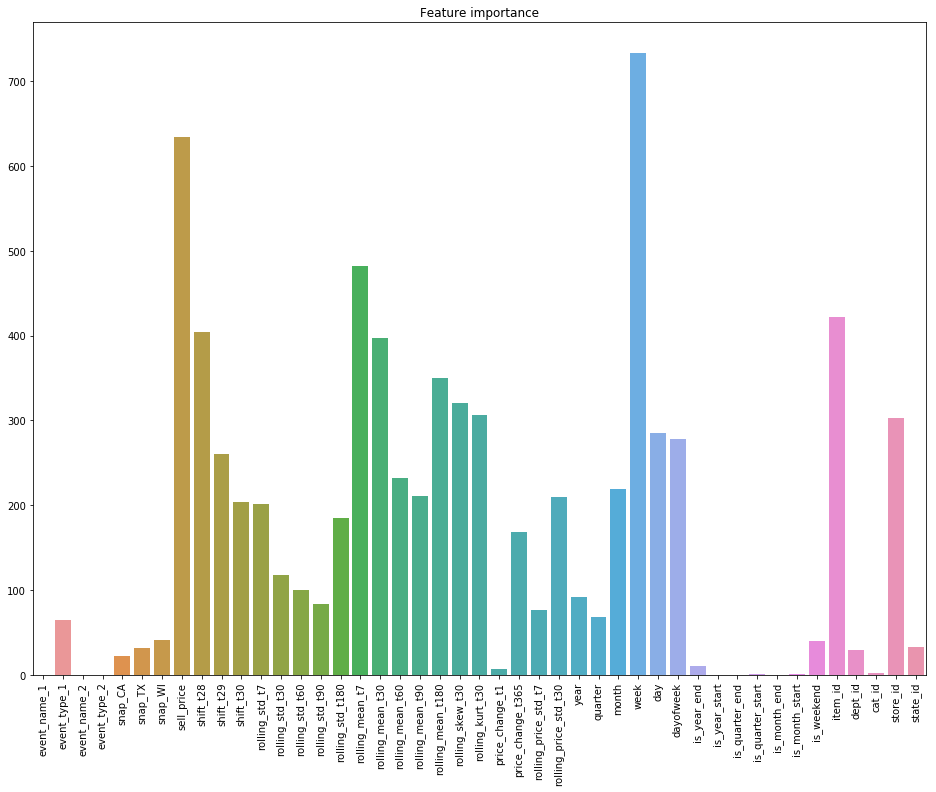

In [33]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(16, 12))
sns.barplot(x = features, y  = model.feature_importance())
plt.xticks(rotation=90)
plt.title('Feature importance')
plt.show()

In [12]:
lgb_feats = ['event_type_1', 'snap_CA', 'snap_TX', 'snap_WI', 'sell_price', 'shift_t28', 
             'shift_t29', 'shift_t30', 'rolling_std_t7', 'rolling_std_t30', 'rolling_std_t60',
             'rolling_std_t90', 'rolling_std_t180', 'rolling_mean_t7',
             'rolling_mean_t30', 'rolling_mean_t60', 'rolling_mean_t90',
             'rolling_mean_t180', 'rolling_skew_t30', 'rolling_kurt_t30',
             'price_change_t365', 'rolling_price_std_t7', 'rolling_price_std_t30', 'year', 
             'quarter', 'month', 'week', 'day', 'dayofweek', 'is_weekend', 'item_id', 'dept_id',
             'store_id', 'state_id']


### Lasso Regression

In [13]:
from sklearn.linear_model import Lasso

In [14]:
for column in features:
    max_value = x_train.loc[x_train[column] != np.inf, column].max()
    x_train[column].replace(np.inf, max_value, inplace=True)
    min_value = x_train.loc[x_train[column] != -np.inf, column].min()
    x_train[column].replace(-np.inf, min_value, inplace=True)

In [15]:
clf = Lasso(alpha=0.05)
clf.fit(x_train[features], y_train)

/opt/conda/envs/Python-3.6/lib/python3.6/site-packages/numpy/core/_methods.py:36: RuntimeWarning: overflow encountered in reduce
  return umr_sum(a, axis, dtype, out, keepdims, initial)


Lasso(alpha=0.05, copy_X=True, fit_intercept=True, max_iter=1000,
   normalize=False, positive=False, precompute=False, random_state=None,
   selection='cyclic', tol=0.0001, warm_start=False)

Text(0.5, 1.0, 'Feature importance Lasso')

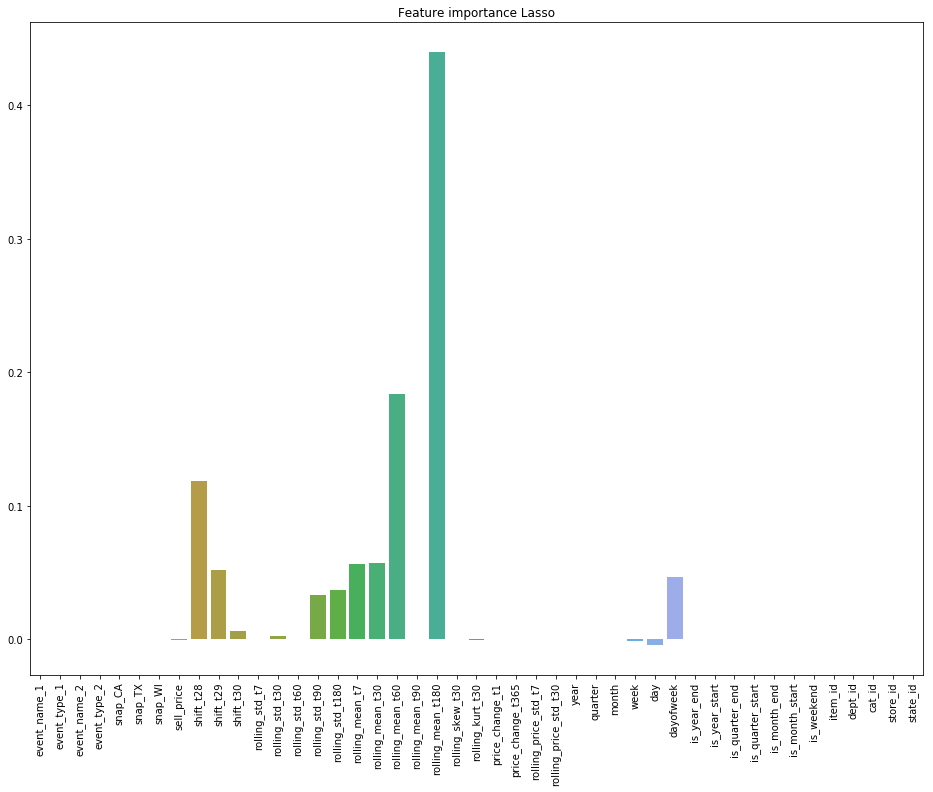

In [16]:
plt.figure(figsize=(16, 12))
sns.barplot(x = features, y  = clf.coef_)
plt.xticks(rotation=90) 
plt.title('Feature importance Lasso')

In [17]:
lasso_features = ["shift_t28", "shift_t29", "shift_t30", "rolling_std_t90", "rolling_std_t180", "rolling_mean_t7",
                  "rolling_mean_t30", "rolling_mean_t30", "rolling_mean_t60", "rolling_mean_t180", "week", "day", "dayofweek"]

In [31]:
from sklearn.linear_model import ElasticNet

clf = ElasticNet(alpha=0.05)
clf.fit(x_train[features], y_train)

/opt/conda/envs/Python-3.6/lib/python3.6/site-packages/numpy/core/_methods.py:36: RuntimeWarning: overflow encountered in reduce
  return umr_sum(a, axis, dtype, out, keepdims, initial)


ElasticNet(alpha=0.05, copy_X=True, fit_intercept=True, l1_ratio=0.5,
      max_iter=1000, normalize=False, positive=False, precompute=False,
      random_state=None, selection='cyclic', tol=0.0001, warm_start=False)

Text(0.5, 1.0, 'Feature importance ElasticNet')

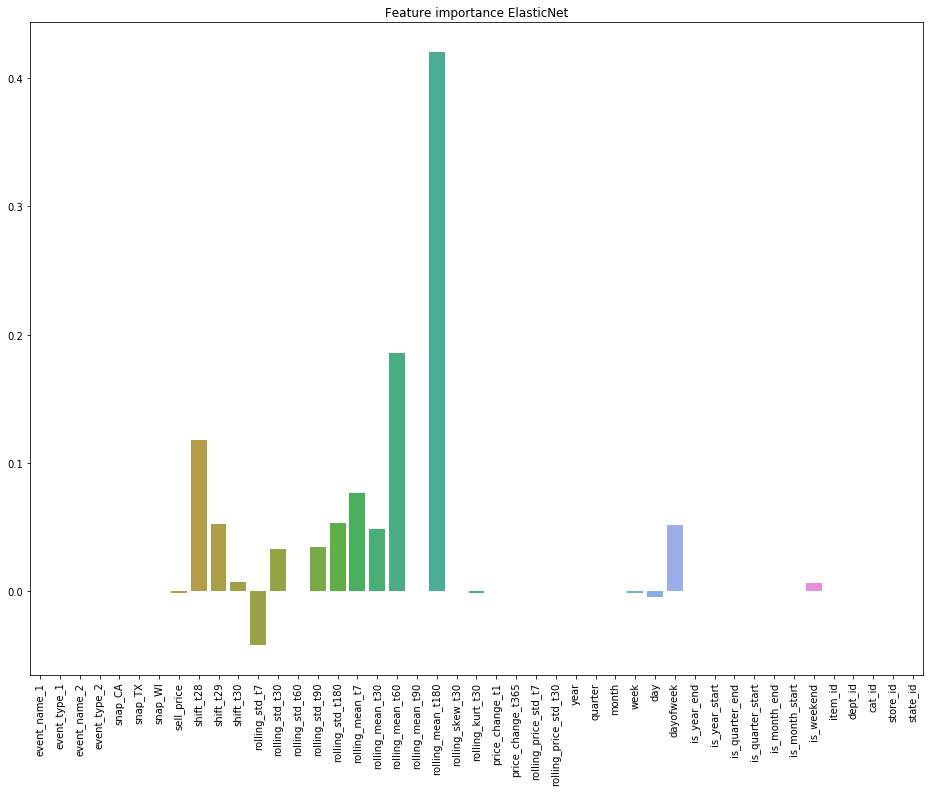

In [32]:
plt.figure(figsize=(16, 12))
sns.barplot(x = features, y  = clf.coef_)
plt.xticks(rotation=90)
plt.title('Feature importance ElasticNet')

In [21]:
elastic_net_feats = ["shift_t28", "shift_t29", "shift_t30", "rolling_std_t180", "rolling_mean_t7", 
                     "rolling_mean_t30", "rolling_mean_t60", "rolling_mean_t90", "rolling_mean_t180",
                     "rolling_kurt_t30", "dayofweek", "week", "day"]

In [25]:
elastic_net_feats = set(elastic_net_feats)
lasso_features = set(lasso_features)
lgb_feats = set(lgb_feats)